## Loading Rate Voltage Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# change file name
filename = r"C:\Users\Aditi\Downloads\PD30w2.txt"

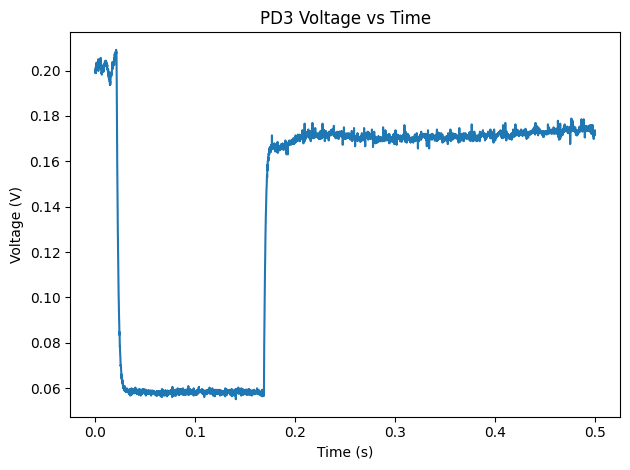

In [4]:
voltages = []
start_reading = False

with open(filename, "r") as f:
    for line in f:
        line = line.strip()

        # start reading after the Voltage header
        if line.startswith("Voltage"):
            start_reading = True
            continue

        if start_reading and line:
            voltages.append(float(line))

voltages = np.array(voltages)

# create time axis
fs = 10000  # Hz
t = np.arange(len(voltages)) / fs

plt.figure()
plt.plot(t, voltages)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("PD3 Voltage vs Time")
plt.tight_layout()
plt.show()


In [5]:
V_room = np.mean(voltages[voltages <= 0.06])
print(f"Mean room light: {V_room}")

Mean room light: 0.05820741577060932


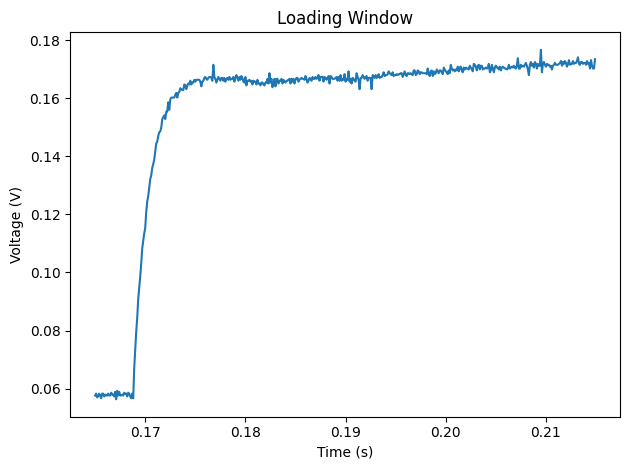

In [6]:
V_zoomed = voltages[1650:]
t_zoomed = t[1650:]
plt.figure()
plt.plot(t_zoomed[:500], V_zoomed[:500])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Loading Window")
plt.tight_layout()
plt.show()

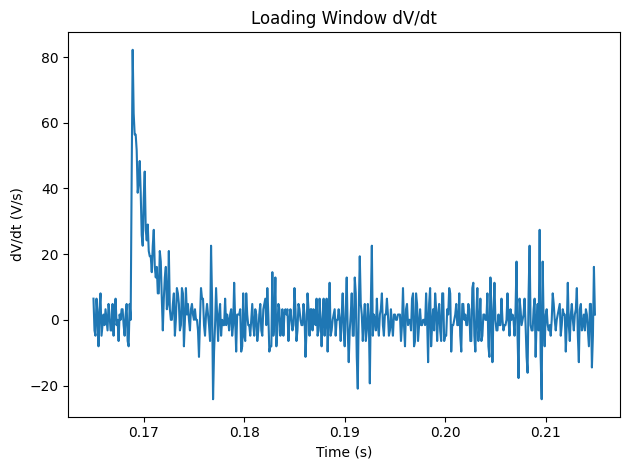

In [7]:
dVdt = np.gradient(V_zoomed, t_zoomed)

plt.figure()
plt.plot(t_zoomed[:500], dVdt[:500])
plt.xlabel("Time (s)")
plt.ylabel("dV/dt (V/s)")
plt.title("Loading Window dV/dt")
plt.tight_layout()
plt.show()


In [8]:
# Calculate turn on time
i0 = np.argmax(dVdt)
t0 = t_zoomed[i0]
print(t0)
i0_switch = i0 + 60


0.1689


Loading window length: 2401


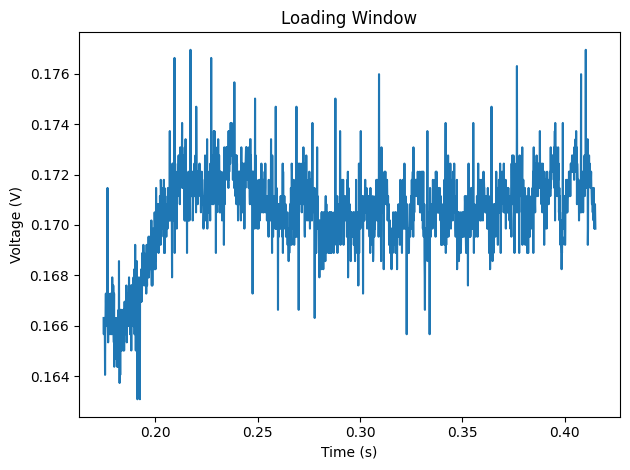

In [9]:
V_loading_window = V_zoomed[i0_switch:2500]
print(f"Loading window length: {len(V_loading_window)}")

t_loading_window = t_zoomed[i0_switch:2500]
plt.figure()
plt.plot(t_loading_window, V_loading_window)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Loading Window")
plt.tight_layout()
plt.show()

In [10]:
t_rel = t_loading_window - t_loading_window[0]

# Model: V(t) = Vbg + A*(1 - exp(-t/tau))
def loading_model(t, Vbg, A, tau):
    return Vbg + A * (1 - np.exp(-t / tau))

Vbg0 = np.mean(V_loading_window[:max(5, int(0.001 / np.median(np.diff(t_loading_window))))])  # ~first 1 ms
Vf0  = np.mean(V_loading_window[-max(5, int(0.002 / np.median(np.diff(t_loading_window)))):]) # ~last 2 ms
A0 = max(Vf0 - Vbg0, 1e-6)
tau0 = (t_rel[-1] - t_rel[0]) / 3 if t_rel[-1] > 0 else 0.002

p0 = [Vbg0, A0, tau0]
bounds = ([-np.inf, 0.0, 1e-9], [np.inf, np.inf, np.inf])  # enforce A>0, tau>0

popt, pcov = curve_fit(loading_model, t_rel, V_loading_window, p0=p0, bounds=bounds, maxfev=20000)
Vbg, A, tau = popt
Vf = Vbg + A
R_volts_per_s = A / tau

Vbg = 0.164159 ± 0.000197 V
A   = 0.006794 ± 0.000195 V
tau = 0.015748 ± 0.000697 s
Vf  = 0.170952 V
Loading rate (proportional) A/tau = 0.431419 V/s


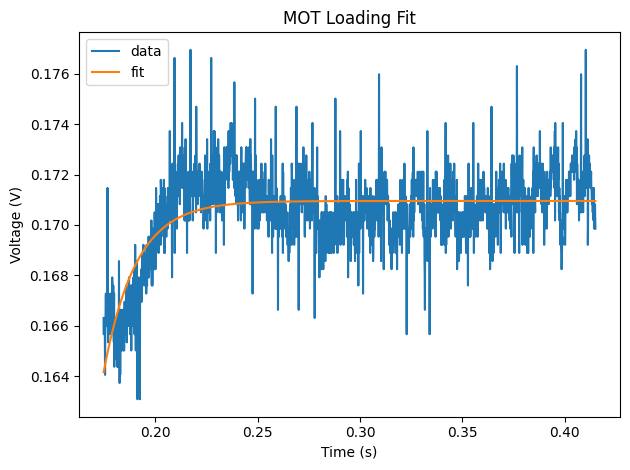

In [11]:
# 1-sigma uncertainties
perr = np.sqrt(np.diag(pcov))
Vbg_err, A_err, tau_err = perr

print(f"Vbg = {Vbg:.6f} ± {Vbg_err:.6f} V")
print(f"A   = {A:.6f} ± {A_err:.6f} V")
print(f"tau = {tau:.6f} ± {tau_err:.6f} s")
print(f"Vf  = {Vf:.6f} V")
print(f"Loading rate (proportional) A/tau = {R_volts_per_s:.6f} V/s")

# 5) Plot data + fit
plt.figure()
plt.plot(t_loading_window, V_loading_window, label="data")
plt.plot(t_loading_window, loading_model(t_rel, *popt), label="fit")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("MOT Loading Fit")
plt.legend()
plt.tight_layout()
plt.show()

### Fluorescence (Scattering) Rate per Atom

The rate at which a single atom scatters photons from the MOT light fields is

$$
R_{\text{sc}}=\frac{\Gamma}{2}\frac{s}{1+s+\left(\frac{2\Delta}{\Gamma}\right)^2}
$$

where $\Gamma$ is the natural linewidth, $\Delta$ is the laser detuning from resonance, and $s=I/I_{\text{sat}}$ is the saturation parameter.

For the Rb $D_2$ transition,
$$
\Gamma \approx 2\pi \times 6.07~\text{MHz}.
$$

We estimate the intensity at the atom cloud from the measured beam power $P$ and beam radius $w$ (Gaussian beam) as
$$
I \approx \frac{2P}{\pi w^2},
$$
and use $I_{\text{sat}} \approx 1.7~\text{mW/cm}^2$ for the cycling transition.

Beam diameter:
0.8 cm 
0.9 cm
0.92 cm
0.85 cm

Input Power:
- x: 5.426 mW
- y: 5.734 mW
- z: 9.26 mW



In [12]:
# Calculate Scattering Rate 
eom_drive_MHz = 2917.876
atomic_transition_MHz = 2915.0

detuning_MHz = 2*np.pi*(eom_drive_MHz - atomic_transition_MHz)

natural_lw_MHz = 2*np.pi*6.07

### Fluorescence (Scattering) Rate per Atom

# mean beam radius w
omega_mean = np.mean([0.008/2, 0.009/2, 0.0092/2, 0.0085/2])

# intensity at MOT
def I_MOT(Px,Py,Pz):
    Ix = 2*Px/(np.pi*omega_mean**2)
    Iy = 2*Py/(np.pi*omega_mean**2)
    Iz = 2*Pz/(np.pi*omega_mean**2)
    return 2*(Ix + Iy + Iz)

def scattering_rate(natural_lw_MHz, Px, Py, Pz, I_sat, detuning_MHz):
    I = I_MOT(Px,Py,Pz)
    print(f"Intensity at MOT (W): {I}")
    s = I/I_sat
    detuning = detuning_MHz*1e6
    natural_lw = natural_lw_MHz*1e6
    print(f"Saturation parameter (s): {s}")

    frac = s/(1+s+(2*detuning/natural_lw)**2)
    scat_rate = natural_lw * frac / 2
    print(f"Scatter rate: {scat_rate}")
    return scat_rate


In [13]:
Px, Py, Pz = 0.005426, 0.005734, 0.00926
R_sc = scattering_rate(natural_lw_MHz,Px,Py,Pz,17.0,detuning_MHz)


Intensity at MOT (W): 1381.932659704415
Saturation parameter (s): 81.2901564532009
Scatter rate: 18634390.641722724


In [14]:
scatter = R_sc/1e6
print(scatter)

18.634390641722725


In [15]:
import numpy as np

# --- Detuning ---
eom_drive_MHz = 2917.876
atomic_transition_MHz = 2915.0

Delta_rad_s = 2*np.pi*(eom_drive_MHz - atomic_transition_MHz)*1e6  # rad/s

# --- Rb D2 linewidth ---
Gamma_rad_s = 2*np.pi*6.07e6   # rad/s

# --- Saturation intensity ---
I_sat = 17.0  # W/m^2  (1.7 mW/cm^2)

# --- Mean beam radius (meters) ---
omega_mean = np.mean([0.008/2, 0.009/2, 0.0092/2, 0.0085/2])  # meters

# --- Total MOT intensity ---
def I_MOT(Px, Py, Pz):
    Ix = 2*Px/(np.pi*omega_mean**2)
    Iy = 2*Py/(np.pi*omega_mean**2)
    Iz = 2*Pz/(np.pi*omega_mean**2)
    return 2*(Ix + Iy + Iz)   # factor 2 for counter-propagating beams

def scattering_rate(Px, Py, Pz):
    I = I_MOT(Px, Py, Pz)
    s = I / I_sat

    frac = s / (1 + s + (2*Delta_rad_s/Gamma_rad_s)**2)
    R_sc = (Gamma_rad_s/2) * frac

    print(f"Beam radius w = {omega_mean*1e3:.2f} mm")
    print(f"Total intensity = {I:.2f} W/m^2 = {I/10:.2f} mW/cm^2")
    print(f"Saturation parameter s = {s:.2f}")
    print(f"Scattering rate R_sc = {R_sc:.2e} s^-1")
    print(f"Maximum possible (Γ/2) = {Gamma_rad_s/2:.2e} s^-1")

    return R_sc

Px, Py, Pz = 0.005426, 0.005734, 0.00926  # W
R_sc = scattering_rate(Px, Py, Pz)

Beam radius w = 4.34 mm
Total intensity = 1381.93 W/m^2 = 138.19 mW/cm^2
Saturation parameter s = 81.29
Scattering rate R_sc = 1.86e+07 s^-1
Maximum possible (Γ/2) = 1.91e+07 s^-1


In [16]:
# ---- inputs (in mm) ----
d_mm = 14.5      # distance from MOT to limiting aperture (lens) [mm]
D_mm = 5.5       # clear diameter of lens (or limiting aperture) [mm]

# ---- compute ----
a_mm = D_mm / 2.0
theta = np.arctan(a_mm / d_mm)                 # half-angle in rad
Omega = 2*np.pi*(1 - np.cos(theta))            # solid angle in sr
eta = Omega / (4*np.pi)                        # fraction of isotropic emission

print(f"Lens radius a = {a_mm:.3f} mm")
print(f"Distance d    = {d_mm:.3f} mm")
print(f"Half-angle θ  = {np.degrees(theta):.3f} deg ({theta:.6f} rad)")
print(f"Solid angle Ω = {Omega:.6f} sr")
print(f"Collected fraction Ω/4π = {eta:.6%}")

Lens radius a = 2.750 mm
Distance d    = 14.500 mm
Half-angle θ  = 10.739 deg (0.187429 rad)
Solid angle Ω = 0.110040 sr
Collected fraction Ω/4π = 0.875674%


Photodetector Efficiency (A/W) @ 780 nm - DET100A ThorLabs: ~ 0.47 A/W

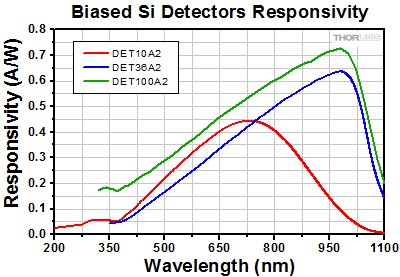 

PD3 Input Impedance: 1 MOhm

Mean saturation voltage: 0.17093275719000472 V


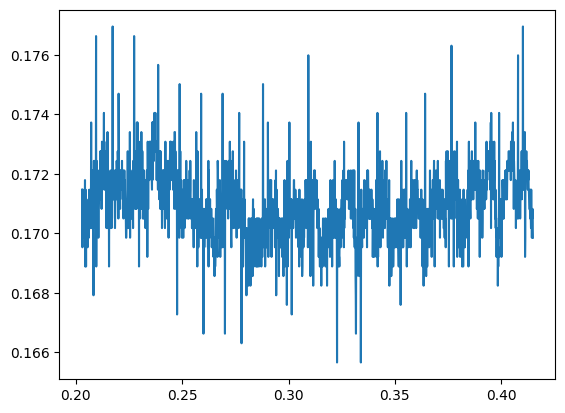

In [17]:
clip_index = 280
V_saturation_window = V_loading_window[clip_index:]
plt.plot(t_loading_window[clip_index:], V_loading_window[clip_index:], label="data")
sat_voltage = np.mean(V_loading_window[clip_index:])
print(f"Mean saturation voltage: {sat_voltage} V")

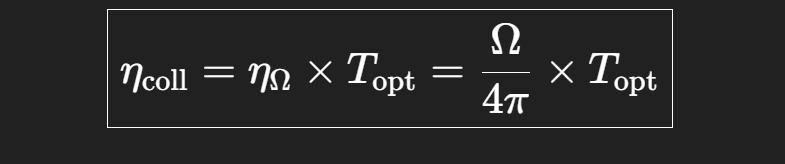

In [18]:
def pd3_VtoW(voltages, impedance_ohm, responsivity_aw):
    return voltages / (impedance_ohm*responsivity_aw)

def pd3_photon_detection_rate(powers, omega, T_opt=0.9):
    h = 6.626e-34
    c = 2.99e8
    lamb = 780e-9
    E_per_photon = h*c/lamb
    collection_efficiency = omega*T_opt/(4*np.pi)
    print(f"{collection_efficiency=}")
    return powers/E_per_photon




In [19]:
impedance_ohm = 1e6
responsivity_aw = 0.45
V_to_W = pd3_VtoW(V_saturation_window, impedance_ohm,responsivity_aw)
print(f"Mean Power at Saturation: {np.mean(V_to_W)*1e6} uW")
photon_detection_rate = pd3_photon_detection_rate(V_to_W, Omega)
print(f"Mean Photon Detection Rate: {np.mean(photon_detection_rate)} photons/S")

Mean Power at Saturation: 0.3798505715333438 uW
collection_efficiency=0.007881064061869681
Mean Photon Detection Rate: 1495494316985.8289 photons/S
